In [17]:
#imports

import pandas as pd
import numpy as np
import json
import matplotlib
%matplotlib inline

# Outline

- Begin the process by taking a look at the *training* data basic features:
    - Event code counts
    - unique installations
    - unique sessions
- Add another layer by looking at grouped features:
    - group by installation id: game time, event code counts,
    - group by session within an installation
- Compare train and test data as a reality check
- Unpack inner data
    - event data
    - specs args
- Join the train_labels to train data
- Set up an initial naive baseline

In [3]:
#Read in training data first
train = pd.read_csv("data-science-bowl-2019/train.csv")

In [4]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [5]:
train.shape

(11341042, 11)

In order to explore the features more easily let's sample a small piece of the total. Total shape has over 11 million observations.
It's also worth noting that some of the installation ids in the training data don't contain assessments so we can eliminate those as they are not useful for training.

In [6]:
hasAssessmentIds = train[train["type"] == "Assessment"].loc[:,'installation_id'].drop_duplicates()
useful_train = pd.merge(train, hasAssessmentIds, on="installation_id", how="inner")

In [7]:
useful_train.shape

(8294138, 11)

In [8]:
train_sample = useful_train.sample(100000)

Let's list out the columns we're going to need to look at for each observation.

In [9]:
train_sample.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world'],
      dtype='object')

It seems like it could be useful to categorize different observations in the data. Event codes could represent some of these differences.

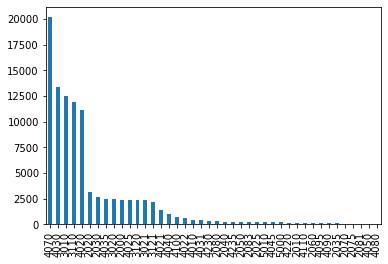

In [10]:
train_sample["event_code"].value_counts().plot.bar()

In [28]:
train_sample.groupby("installation_id").sum()

,event_count,event_code,game_time
installation_id,,,
0006a69f,2907,163998,3762663
0006c192,1345,77092,1165856
00129856,848,37395,997418
001d0ed0,481,32460,491822
00225f67,675,36520,668930
...,...,...,...
ff9715db,1239,74225,1355872
ffc90c32,962,70992,1194293
ffd2871d,1806,91151,3561018


This tells us there are about 4000 installation ids in the sample and gives us information about total game time.

In [12]:
train_sample.groupby("game_session").sum()

,event_count,event_code,game_time
game_session,,,
0000d473b2f78883,40,4030,57082
00030865234e6b3d,27,8100,38261
000319989d08f8aa,384,24245,442942
00037e484eac6640,156,9230,190573
0007729b666af371,291,16230,436949
...,...,...,...
fffb2fe838347917,133,6230,338772
fffc036248965403,260,10170,212523
fffcdc3a0ff75a77,1040,16260,1457188


Not sure game session ids are telling me what I thought they were here. They don't seem to overlap much, some sessions only contining 1 obseravtion.

Let's take a deeper look at a set of events for a single ID.

In [32]:
single_id = train_sample.query('installation_id=="0006a69f"')
single_id.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
60,9ee1c98c,2b9d5af79bcdb79f,2019-08-06T04:58:51.696Z,"{""size"":2,""sand"":1,""duration"":509,""coordinates...",0006a69f,59,4021,37155,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3397,1996c610,60a7cbbd3cdb859f,2019-08-29T16:21:34.614Z,"{""shell_size"":2,""round"":3,""event_count"":82,""ga...",0006a69f,82,4031,93099,Dino Drink,Game,MAGMAPEAK
479,27253bdc,7fb287ace174adee,2019-08-06T05:17:35.568Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Tree Top City - Level 2,Clip,TREETOPCITY
89,5e812b27,2b9d5af79bcdb79f,2019-08-06T04:59:25.042Z,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,88,4030,70490,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3088,a29c5338,b478a149cebc4934,2019-08-09T18:32:36.762Z,"{""description"":""There are two holes and two di...",0006a69f,18,3010,34834,Dino Drink,Game,MAGMAPEAK


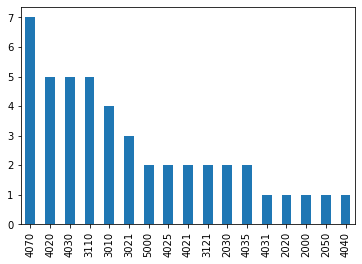

In [34]:
single_id["event_code"].value_counts().plot.bar()

In [38]:
#This user has 25 different game sessions
single_id["game_session"].value_counts().count()

25

In [40]:
single_id["type"].value_counts()

Activity      23
Game          21
Clip           1
Assessment     1
Name: type, dtype: int64

It might be interesting to compare some features in the train data to the test data, as a reality check that things are relatively similar.

In [13]:
test = pd.read_csv("data-science-bowl-2019/test.csv")

In [14]:
test.shape

(1156414, 11)

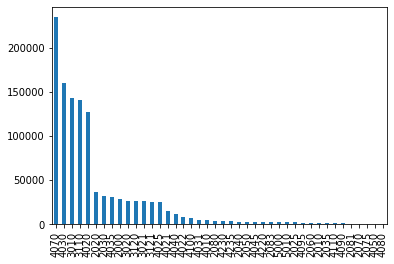

In [24]:
test["event_code"].value_counts().plot.bar()

Event code, at least, looks fairly similar. That's good!
Next, let's look at various other statistics.

In [25]:
display(train_sample["event_code"].nunique())
display(test["event_code"].nunique())

42

42

In [26]:
display(train_sample["event_id"].nunique())
display(test["event_id"].nunique())

361

365

In [36]:
display(train_sample["installation_id"].nunique())
display(test["installation_id"].nunique())

4071

1000

Unpack the inner data

In [18]:
# Code below based on code original written/published by Gabriel Preda
# on Kaggle, accessed Mon, 18 Nov, 2019
# https://www.kaggle.com/gpreda/2019-data-science-bowl-eda
extracted_event_data = pd.io.json.json_normalize(train_sample.event_data.apply(json.loads))

In [20]:
extracted_event_data.shape

(100000, 136)

In [21]:
extracted_event_data.head()

,hat,caterpillar,hats,caterpillars,source,event_count,game_time,event_code,coordinates.x,coordinates.y,...,max_position,end_position,dwell_time,time_played,containers,exit_type,tape_length,bug_length,molds,chests
0,0.0,left,"[0, 0, 0]","[5, 8, 5]",N/A,65,46316.0,4030,64.0,486.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,4,373,637758.0,4030,185.0,599.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,35,45936.0,4070,269.0,456.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,38,79309.0,4070,198.0,345.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,29,29531.0,4070,352.0,335.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


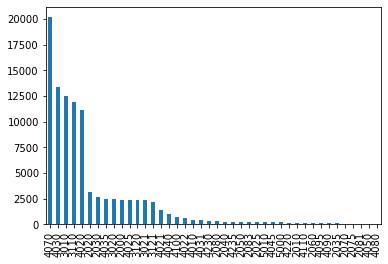

In [23]:
extracted_event_data["event_code"].value_counts().plot.bar()

Join the labels to the training set.

In [44]:
train_labels = pd.read_csv("data-science-bowl-2019/train_labels.csv")

In [45]:
# Code below based on code original written/published by Gabriel Preda
# on Kaggle, accessed Mon, 18 Nov, 2019
# https://www.kaggle.com/gpreda/2019-data-science-bowl-eda

numerical_columns = ['game_time']
categorical_columns = ['type', 'world']

comp_train_sample = pd.DataFrame({'installation_id': train_sample['installation_id'].unique()})
comp_train_sample.set_index('installation_id', inplace = True)

In [46]:
def get_numeric_columns(df, column):
    df = df.groupby('installation_id').agg({f'{column}': ['mean', 'sum', 'min', 'max', 'std', 'skew']})
    df[column].fillna(df[column].mean(), inplace = True)
    df.columns = [f'{column}_mean', f'{column}_sum', f'{column}_min', f'{column}_max', f'{column}_std', f'{column}_skew']
    return df

In [47]:
for i in numerical_columns:
    comp_train_sample = comp_train_sample.merge(get_numeric_columns(train_sample, i), left_index = True, right_index = True)

/home/maxwell/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [48]:
# get the mode of the title
labels_map = dict(train_labels.groupby('title')['accuracy_group'].agg(lambda x:x.value_counts().index[0]))
# merge target
labels = train_labels.loc[:, ['installation_id', 'title', 'accuracy_group']]
# replace title with the mode
labels['title'] = labels['title'].map(labels_map)
# join train with labels
comp_train_sample = labels.merge(comp_train_sample, on = 'installation_id', how = 'left')
print('We have {} training rows'.format(comp_train_sample.shape[0]))

We have 17690 training rows


This gives us the number of rows we can actually use in a future model.

## Let's establish a naive baseline model to work from

In [51]:
# Code below based on code original written/published by Massoud Hosseinali
# on Kaggle, accessed 20 Nov, 2019
# https://www.kaggle.com/mhviraf/a-baseline-for-dsb-2019
submission = pd.read_csv("data-science-bowl-2019/sample_submission.csv")

In [52]:
labels_map = dict(train_labels.groupby('title')['accuracy_group'].agg(lambda x:x.value_counts().index[0])) # get the mode
labels_map

{'Bird Measurer (Assessment)': 0,
 'Cart Balancer (Assessment)': 3,
 'Cauldron Filler (Assessment)': 3,
 'Chest Sorter (Assessment)': 0,
 'Mushroom Sorter (Assessment)': 3}

In [56]:
submission['accuracy_group'] = test.groupby('installation_id').last()['title'].map(labels_map).reset_index(drop=True)
submission.to_csv('submission.csv', index=None)
display(submission.shape)
submission.head()

(1000, 2)

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


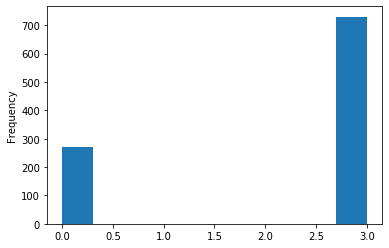

In [54]:
submission['accuracy_group'].plot(kind='hist')

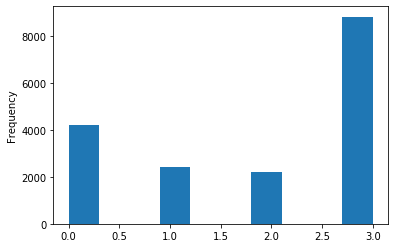

In [55]:
train_labels['accuracy_group'].plot(kind='hist')